# MNIST Assignment

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Chapeter 3 - 신경망

### Activation function

In [2]:
def step(x):
    return np.array(x > 0, dtype=np.int32)

def sigmoid(x):
    return np.array(1 / (1 + np.exp(-x)))

def relu(x):
    return np.array(np.maximum(0, x))

def softmax(x):
    t = np.exp(x - np.max(x))
    return np.array(t / np.sum(t))

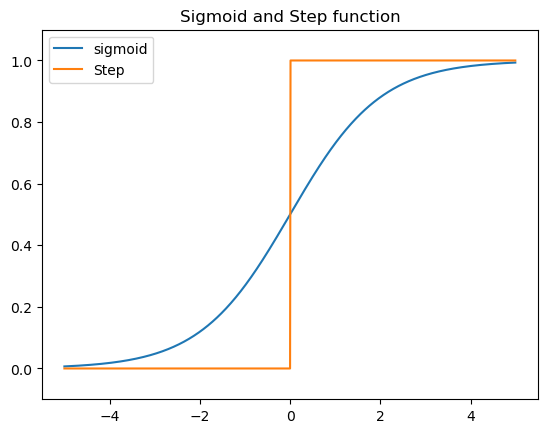

In [3]:
x = np.arange(-5, 5, 0.01)
y_sigmoid = sigmoid(x)
y_step = step(x)

plt.plot(x, y_sigmoid, label="sigmoid")
plt.plot(x, y_step, label="Step")
plt.legend()
plt.ylim(-0.1, 1.1)
plt.title("Sigmoid and Step function")
plt.show()

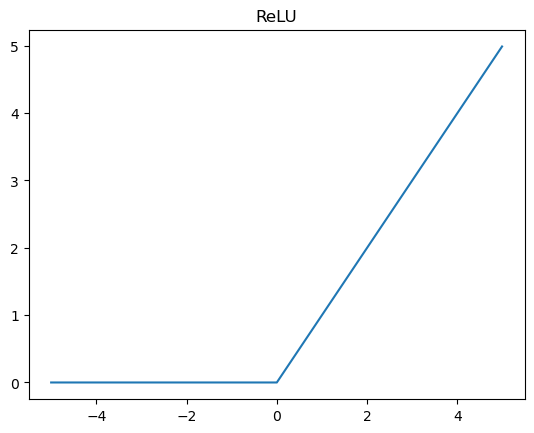

In [4]:
y_relu = relu(x)
plt.plot(x, y_relu)
plt.title("ReLU")
plt.show()

### Example neural network at chapter 3.4

In [5]:
def init_network():
    network = {}
    network["W1"] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    network["B1"] = np.array([0.1, 0.2, 0.3])
    network["W2"] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    network["B2"] = np.array([0.1, 0.2])
    network["W3"] = np.array([[0.1, 0.3], [0.2, 0.4]])
    network["B3"] = np.array([0.1, 0.2])
    
    return network
    
def forward(X, network, activation_fn, output_classifier):
    W1, W2, W3 = network["W1"], network["W2"], network["W3"]
    B1, B2, B3 = network["B1"], network["B2"], network["B3"]
    
    a1 = np.dot(X, W1) + B1
    z1 = activation_fn(a1)
    a2 = np.dot(z1, W2) + B2
    z2 = activation_fn(a2)
    a3 = np.dot(z2, W3) + B3
    y = output_classifier(a3)
    
    return y

In [6]:
network = init_network()
x = np.array([1.0, 0.5])
y = forward(x, network, sigmoid, softmax)

print(y)

[0.40625907 0.59374093]


### Load MNIST Dataset

In [7]:
import pickle
from data.load_mnist import load_mnist

def get_data():
    (X_train, T_train), (X_test, T_test) = load_mnist()
    return X_test, T_test


### Example neural network at chapter 3.6

In [8]:
def init_network():
    with open("data/sample_weight.pkl", "rb") as f:
        return pickle.load(f)

def predict(network, X, activation_fn, output_classifier):
    W1, W2, W3 = network["W1"], network["W2"], network["W3"]
    B1, B2, B3 = network["b1"], network["b2"], network["b3"]

    a1 = np.dot(X, W1) + B1
    z1 = activation_fn(a1)
    a2 = np.dot(z1, W2) + B2
    z2 = activation_fn(a2)
    a3 = np.dot(z2, W3) + B3
    y = output_classifier(a3)

    return y

In [9]:
X, T = get_data()
network = init_network()

batch_size = 100
accuracy_count = 0

for i in range(0, len(X), batch_size):
    Y_batch = predict(network, X[i:i+batch_size], sigmoid, softmax)
    p = np.argmax(Y_batch, axis=1)
    
    accuracy_count += np.sum(p == T[i:i+batch_size])
        
print(f"Accuracy: {float(accuracy_count) / len(X)}")

Accuracy: 0.9352


## Chapter 4 - 신경망 학습

### Loss Function

In [10]:
def sse(y, t):
    return np.sum(np.square(y - t)) / 2

def cee(y, t, delta=1e-7):
    return -np.sum(t * np.log(y + delta))

In [11]:
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
print(sse(y, t))
t2 = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
print(sse(y, t2))

0.09750000000000003
0.5975


In [12]:
print(cee(y, t))
print(cee(y, t2))

0.510825457099338
2.302584092994546


### Mini Batch

In [13]:
(X_train, T_train), (X_test, T_test) = load_mnist(normalize=True, one_hot_label=True)

train_size = X_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)

X_batch = X_train[batch_mask]
T_batch = T_train[batch_mask]

In [14]:
def cee(y, t, delta=1e-7):
    if y.ndim == 1:
        y = y.reshape(1, y.size)
        t = t.reshape(1, t.size)
    
    batch = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch), t] + delta)) / batch

### Differential

In [15]:
def numerical_diff(f, x, delta_x=1e-4):
    return (f(x+delta_x) - f(x-delta_x)) / (2 * delta_x)

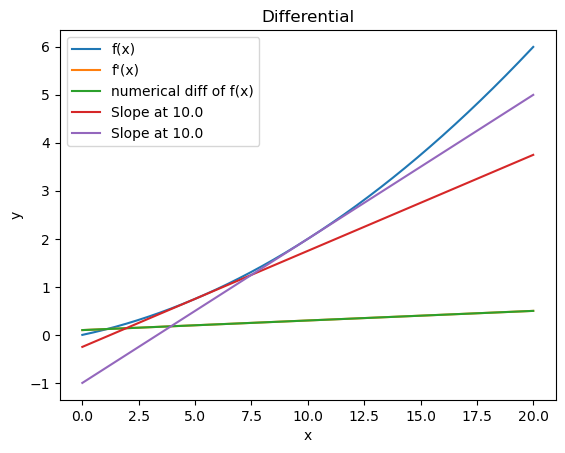

In [16]:
def f(x):
    return 0.01 * (x ** 2) + 0.1 * x

def df(x):
    return 0.02 * x + 0.1

def slope(f, x):
    d = numerical_diff(f, x)
    y = f(x) - d * x
    return lambda t: d * t + y

x = np.arange(0.0, 20.0, 0.01)
y = f(x)
dy = df(x)
numerical_diff_y = numerical_diff(f, x)
tangent_f_at_5 = slope(f, 5)
tangent_line_5 = tangent_f_at_5(x)
tangent_f_at_10 = slope(f, 10)
tangent_line_10 = tangent_f_at_10(x)

plt.plot(x, y, label="f(x)")
plt.plot(x, dy, label="f'(x)")
plt.plot(x, numerical_diff_y, label="numerical diff of f(x)")
plt.plot(x, tangent_line_5, label="Slope at 10.0")
plt.plot(x, tangent_line_10, label="Slope at 10.0")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Differential")
plt.show()

### Partial Differential

In [17]:
def _numerical_gradient_no_batch(f, x, delta_x):
    grad = np.zeros_like(x)
    
    for i in range(x.size):
        x[i] += delta_x
        fxh1 = f(x)
        
        x[i] -= 2 * delta_x
        fxh2 = f(x)
        
        grad[i] = (fxh1 - fxh2) / (2 * delta_x)
        x[i] += delta_x
        
    return grad

def numerical_gradient(f, X, delta_x=1e-4):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X, delta_x)
    
    grad = np.zeros_like(X)
    
    for i, x in enumerate(X):
        grad[i] = _numerical_gradient_no_batch(f, x, delta_x)
    
    return grad

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


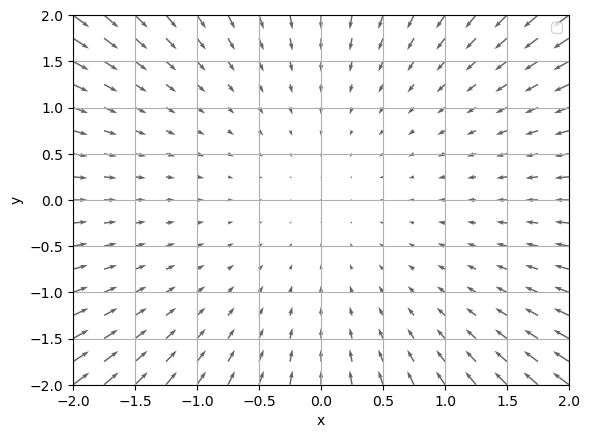

In [23]:
def f_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    return np.sum(x**2, axis=1)

def slope(f, x):
    d = numerical_diff(f, x)
    y = f(x) - d * x
    return lambda t: d * t + y

x0 = np.arange(-2.5, 2.5, 0.25)
x1 = np.arange(-2.5, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)
X, Y = X.flatten(), Y.flatten()

grad = numerical_gradient(f_2, np.array([X, Y]))

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1], angles="xy", color="#666666")# headwidth=10, scale=40, color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.draw()
plt.show()